## **Retrieval-Augmented Agent Project**

## 1. **System Overview**

This project implements an agentic Retrieval-Augmented Generation (RAG) system focused on the domain of industrial chemical safety and process safety management. The goal of the system is to provide accurate, context-aware responses to user queries by intelligently deciding when to rely on general language model knowledge and when to retrieve authoritative information from a specialized document corpus.

The system is built using LangGraph, with an agent node responsible for reasoning and decision-making, and a tool node connected to a document retrieval function backed by a Chroma vector store. Domain-specific documents, including safety guidelines, risk assessment procedures, and emergency response materials, are embedded and stored to enable semantic search.

A conditional control flow allows the agent to determine whether document retrieval is necessary based on the nature of the user query. General or conversational questions are answered directly, while technical or safety-critical questions trigger retrieval before response generation. Conversation memory is integrated to support multi-turn interactions within a session, enabling coherent and context-aware dialogue. The system supports both single-query execution and an interactive chat interface for user interaction.

**Note** : Remember to do edit this later before sumission

In [1]:
# Imports
from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from IPython.display import Image, display, Markdown, HTML, Latex
from langchain_core.documents import Document
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_chroma import Chroma
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from dotenv import load_dotenv
from typing import Literal
import logging
import time
import os
import re
import warnings
warnings.filterwarnings("ignore")

c:\Users\olasunkanmi\Desktop\my_task\.allenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Implementation

In [2]:
# Load API key
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")

if not openai_api_key:
    raise ValueError("OPENAI_API_KEY not found! Please set it in your .env file.")

print("API key loaded")

API key loaded


In [3]:
# Initialize LLM
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
    api_key=openai_api_key
)

print(f"LLM initialized: {llm.model_name}")

LLM initialized: gpt-4o-mini


In [4]:
# Prevent messy PDF logs
logging.getLogger("pypdf").setLevel(logging.ERROR)

# file path
file_path = "./documents"

async def load_all_pdfs(pdf_dir: str):
    pages = []

    for filename in os.listdir(pdf_dir):
        if filename.lower().endswith(".pdf"):
            file_path = os.path.join(pdf_dir, filename)
            loader = PyMuPDFLoader(file_path)

            async for page in loader.alazy_load():
                page.metadata["source"] = filename
                pages.append(page)

    return pages

documents = await load_all_pdfs(file_path)
print(f"Loaded {len(documents)} pages from PDFs")

Loaded 1960 pages from PDFs


In [5]:
def smart_chunk_by_sections(documents, chunk_size=1000, chunk_overlap=100):
    """
    Smart chunking for better retrieval:
    - Skips blank pages
    - Chunks each document independently
    - Prevents bias toward any single document
    """

    print(f"Original documents: {len(documents)}")

    # Intelligent splitter
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        separators=[
            "\n\n",
            "\n",
            ". ",
            " ",
            ""
        ]
    )

    all_chunks = []

    for idx, doc in enumerate(documents):
        content = doc.page_content.strip()

        if not content:
            continue  # Skip blank pages

        # Preserve document identity without bias
        single_doc = Document(
            page_content=content,
            metadata={**doc.metadata, "doc_index": idx}
        )

        doc_splits = text_splitter.split_documents([single_doc])
        all_chunks.extend(doc_splits)

        # print(f"✓ Document {idx + 1}: {len(doc_splits)} chunks")

    print(f"\nTotal chunks created: {len(all_chunks)}")
    return all_chunks


def view_chunks_with_context(chunks, num_chunks_to_show=10):
    """
    Display chunk previews (for sanity checking only)
    """
    print("\n" + "=" * 80)
    print("CHUNK PREVIEW")
    print("=" * 80)

    for i, chunk in enumerate(chunks[:num_chunks_to_show]):
        print(f"\n--- CHUNK {i + 1} ---")
        print(f"Length: {len(chunk.page_content)} characters")
        print("Preview (first 300 chars):")
        print(chunk.page_content[:300])
        print("...")
        if i < num_chunks_to_show - 1:
            print("-" * 40)


if __name__ == "__main__":
    # Chunk the documents (ALL documents treated equally)
    chunks_1000 = smart_chunk_by_sections(
        documents,
        chunk_size=1000,
        chunk_overlap=100
    )

    # # print(f"\n✓ Total chunks: {len(chunks_1000)}")

    # Chunk statistics
    chunk_sizes = [len(c.page_content) for c in chunks_1000]
    print("\nChunk size statistics:")
    print(f"  Min: {min(chunk_sizes)} chars")
    print(f"  Max: {max(chunk_sizes)} chars")
    print(f"  Avg: {sum(chunk_sizes) / len(chunk_sizes):.0f} chars")

    # Optional preview (debug only)
    view_chunks_with_context(chunks_1000, num_chunks_to_show=5)

    print(f"\n{'=' * 80}")
    print("Chunks are ready for unbiased RAG retrieval across all documents.")
    print(f"{'=' * 80}")


Original documents: 1960

Total chunks created: 4435

Chunk size statistics:
  Min: 1 chars
  Max: 1000 chars
  Avg: 782 chars

CHUNK PREVIEW

--- CHUNK 1 ---
Length: 50 characters
Preview (first 300 chars):
Frequently Asked Questions
In
Quantitative Finance
...
----------------------------------------

--- CHUNK 2 ---
Length: 208 characters
Preview (first 300 chars):
Frequently Asked Questions
In
Quantitative Finance
Including key models, important formulæ,
common contracts, a history of quantitative
ﬁnance, sundry lists, brainteasers and more
www.wilmott.com
Paul Wilmott
...
----------------------------------------

--- CHUNK 3 ---
Length: 973 characters
Preview (first 300 chars):
Copyright 2007 Paul Wilmott.
Published in 2007 by
John Wiley & Sons Ltd,
The Atrium, Southern Gate, Chichester,
West Sussex PO19 8SQ, England
Telephone (+44) 1243 779777
Email (for orders and customer service enquiries): cs-books@wiley.co.uk
Visit our Home Page on www.wiley.com
All Rights Reserved.
...
---

In [6]:
# from collections import Counter

# doc_sources = Counter([doc.metadata["doc_index"] for doc in chunks_1000])
# print(doc_sources)


In [7]:
# Initialize embeddings (using OpenAI)
embeddings = OpenAIEmbeddings(
    model="text-embedding-3-small",
    api_key=openai_api_key
)

print("Embeddings model initialized")

Embeddings model initialized


In [8]:
chroma_path = "./chroma_db"
collection_name = "becoming_a_quant"

# Check if Chroma DB already exists
db_exists = os.path.exists(chroma_path) and len(os.listdir(chroma_path)) > 0

if db_exists:
    print("Existing Chroma DB found. Loading...")
    
    vectorstore = Chroma(
        collection_name=collection_name,
        persist_directory=chroma_path,
        embedding_function=embeddings
    )

else:
    print("No existing Chroma DB found. Creating new one...")
    
    vectorstore = Chroma(
        collection_name=collection_name,
        persist_directory=chroma_path,
        embedding_function=embeddings
    ) 
    vectorstore.add_documents(documents=chunks_1000)


    print(f"Vector store created with {len(chunks_1000)} chunks")
    print(f"   Persisted to: {chroma_path}")


Existing Chroma DB found. Loading...


In [9]:
test_query = "What is Algorithmic Trading?"
test_results = vectorstore.similarity_search(test_query, k=2)

print(f"Query: {test_query}")
print("\nRetrieved Chunks:\n")

for i, doc in enumerate(test_results, 1):
    print(f"Result {i}")
    print(f"Source: {doc.metadata.get('source', 'Unknown')}")
    print(f"Content:\n{doc.page_content[:600]}...\n")

Query: What is Algorithmic Trading?

Retrieved Chunks:

Result 1
Source: Successful Algorithmic Trading.pdf
Content:
Part I
Introducing Algorithmic Trading
1...

Result 2
Source: Successful Algorithmic Trading.pdf
Content:
Chapter 2
What Is Algorithmic Trading?
Algorithmic trading, as deﬁned here, is the use of an automated system for carrying out
trades, which are executed in a pre-determined manner via an algorithm speciﬁcally without
any human intervention. The latter emphasis is important. Algorithmic strategies are designed
prior to the commencement of trading and are executed without discretionary input from human
traders.
In this book “algorithmic trading” refers to the retail practice of automated, systematic and
quantitative trading, which will all be treated as synonyms for the purpose of this text. In...



In [10]:
test_query = "Who is Peter Carr?"
test_results = vectorstore.similarity_search(test_query, k=2)

print(f"Query: {test_query}")
print("\nRetrieved Chunks:\n")

for i, doc in enumerate(test_results, 1):
    print(f"Result {i}")
    print(f"Source: {doc.metadata.get('source', 'Unknown')}")
    print(f"Content:\n{doc.page_content[:600]}...\n")

Query: Who is Peter Carr?

Retrieved Chunks:

Result 1
Source: How_I_Became_a_Quant.pdf
Content:
Peter Carr
139
available. I stopped drinking when I turned 18, and I don’t drink at
all today.
I studied accounting and economics as an undergraduate at the
University of Toronto (U. of T.). Unfortunately, they are about the
worst subjects you can learn if you want to become a quant. Luckily,
the requirements for my bachelor of commerce degree required a single
ﬁnance class taken in your third year. That ﬁnance class was taught by
a gifted professor named Dan Thornton who emphasized the use of
physical analogies to explain the math. For example, he used Modigliani
Miller’s explanation of the i...

Result 2
Source: How_I_Became_a_Quant.pdf
Content:
derivative research groups for six years at Banc of America Securities
and at Morgan Stanley. His academic positions include four years as an
adjunct professor at Columbia University and eight years as a ﬁnance
professor at Cornell University. He 

In [11]:
@tool
def retrieve_documents(query: str) -> str:
    """
    Search for relevant documents in the knowledge base.
    
    Use this tool when you need information from the document collection
    to answer the user's question. Do NOT use this for:
    - General knowledge questions
    - Greetings or small talk
    - Simple calculations
    
    Args:
        query: The search query describing what information is needed
        
    Returns:
        Relevant document excerpts that can help answer the question
    """
    # Use MMR (Maximum Marginal Relevance) for diverse results
    retriever = vectorstore.as_retriever(
        search_type="mmr",
        search_kwargs={"k": 5, "fetch_k": 10}
    )
    
    # Retrieve documents
    results = retriever.invoke(query)
    
    if not results:
        return "No relevant documents found."
    
    # Format results
    formatted = "\n\n---\n\n".join(
        f"Document {i+1}:\n"
        f"Source: {doc.metadata.get('source', 'Unknown')}\n"
        f"Page: {doc.metadata.get('page', 'N/A')}\n"
        f"Content:\n{doc.page_content}"
        for i, doc in enumerate(results)
    )
    
    return formatted

print("Retrieval tool created")

Retrieval tool created


In [12]:
test_query = "What is Algorithmic Trading?"

# Test tool directly
test_result = retrieve_documents.invoke({"query": "Explain the Advantages and Disadvantages of Algorithmic Trading."})
print(f"Tool result (first 500 chars):\n{test_result[:500]}...")

Tool result (first 500 chars):
Document 1:
Source: Successful Algorithmic Trading.pdf
Page: 15
Content:
and drawbacks of a systematic approach will be outlined.
2.1.1
Advantages
Algorithmic trading possesses numerous advantages over discretionary methods.
Historical Assessment
The most important advantage in creating an automated strategy is that its performance can
be ascertained on historical market data, which is (hopefully) representative of future market
data. This process is known as backtesting and will be discussed in...


In [35]:
system_prompt = SystemMessage(content="""
You are an assistant specialized in quantitative finance, derivatives pricing, and risk management.
Your knowledge source is a collection of quantitative finance documents and financial modeling resources.

DOMAIN RESTRICTION:
Only answer questions related to:
- Quantitative finance and derivatives pricing
- Risk management and portfolio theory
- Financial modeling and numerical methods (Monte Carlo, finite differences, binomial trees)
- Options pricing, Greeks, and hedging strategies
- Fixed income instruments and interest rate models
- Credit derivatives and structured products
- Volatility modeling and stochastic processes
- Mathematical finance fundamentals (Itô's lemma, Brownian motion, etc.)

If a question is outside this domain AND no relevant information is found in the retrieved documents,
politely respond that it is outside your scope.

If relevant information IS found in the retrieved documents,
answer the question strictly using the documents, even if the topic is outside quantitative finance.

RETRIEVAL DECISION RULES:

DO NOT retrieve for:
- Greetings or small talk ("Hello", "Thank you")
- Questions about your capabilities
- Very general conceptual questions that do NOT depend on the documents
(e.g., "What is finance?")

DO retrieve for:
- Questions requiring procedural steps, formulas, or detailed explanations
- Questions that depend on document-specific information (models, case studies, examples)
- Technical questions about pricing, hedging, or risk management
- Any request where citing documents improves accuracy
- When in doubt about whether a concept is document-backed, prefer retrieval.


When documents are retrieved:
- Use them as the primary source of truth
- Cite the document source, chapter, or page when possible
- Include relevant formulas, equations, or technical details from the documents
- If the documents do not contain the answer, say so explicitly

Never fabricate pricing models, formulas, or quantitative methodologies.
Always distinguish between classical theory and real-world practice.
""")


In [14]:
# Bind tool to LLM
tools = [retrieve_documents]
llm_with_tools = llm.bind_tools(tools)

def assistant(state: MessagesState) -> dict:
    """
    Assistant node - decides whether to retrieve or answer directly.
    """
    # messages = [system_prompt] + state["messages"]
    messages = state["messages"]

    # Inject system prompt only once
    if not messages or messages[0].type != "system":
        messages = [system_prompt] + messages
        
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

def should_continue(state: MessagesState) -> Literal["tools", "__end__"]:
    """
    Decide whether to call tools or finish.
    """
    last_message = state["messages"][-1]

    if last_message.tool_calls:
        return "tools"
    return "__end__"

In [15]:
# Build graph
builder = StateGraph(MessagesState)

# Add nodes
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    should_continue,
    {"tools": "tools", "__end__": END}
)
builder.add_edge("tools", "assistant")

# Add memory
memory = MemorySaver()
agent = builder.compile(checkpointer=memory)

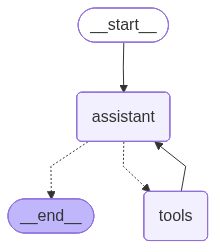

In [16]:
# Visualize the agentic RAG graph
try:
    display(Image(agent.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("Graph: START → assistant → [if tool_call] → tools → assistant → END")

In [ ]:
def convert_latex_for_display(text):
    """
    Converts LaTeX in text to proper Markdown format for Jupyter rendering
    Handles both inline ($...$) and display ($$...$$) math
    """
    if not text:
        return text

    text = re.sub(r'\\\(', '$', text)
    text = re.sub(r'\\\)', '$', text)
    text = re.sub(r'\\\[', '$$\n', text)
    text = re.sub(r'\\\]', '\n$$', text)

    return text


def query_agent(user_input: str, thread_id: str = "default_session"):
    """
    Improved query function with clear, well-formatted output.
    """
    print(f"\n{'='*70}")
    print(f"👤 User: {user_input}")
    print(f"{'='*70}\n")

    result = agent.invoke(
        {"messages": [HumanMessage(content=user_input)]},
        config={"configurable": {"thread_id": thread_id}}
    )

    used_retrieval = False
    final_answer = None

    for message in result["messages"]:
        if isinstance(message, AIMessage):
            if message.tool_calls:
                used_retrieval = True
                print("🔍 Agent: [Calling retrieval tool...]")
            if message.content and not message.tool_calls:
                final_answer = message.content

    if final_answer:
        # Convert LaTeX
        final_answer = convert_latex_for_display(final_answer)

        # Render as Markdown (fixes formulas)
        display(Markdown(f"### 🤖 Agent Response\n\n{final_answer}"))
    else:
        print("⚠️ No response generated after retrieval!")

    print(f"\n📊 Decision: {'USED RETRIEVAL' if used_retrieval else 'ANSWERED DIRECTLY'}")


In [27]:
query_agent("Explain the Discrete Time Models in Quantitative Finance.")


👤 User: Explain the Discrete Time Models in Quantitative Finance.

🔍 Agent: [Calling retrieval tool...]
🔍 Agent: [Calling retrieval tool...]
🔍 Agent: [Calling retrieval tool...]
🔍 Agent: [Calling retrieval tool...]


### 🤖 Agent Response

Discrete time models in quantitative finance are frameworks where asset prices and time progress in finite increments. Here are the key features and concepts associated with these models:

1. **Definition**: Discrete time models allow for changes in asset prices and time to occur only at specific intervals, such as daily, weekly, or monthly. This contrasts with continuous models, where changes can happen at any moment.

2. **Mathematical Framework**: In discrete models, the evolution of asset prices is typically described using difference equations. For example, if $ S_t $ represents the asset price at time $ t $, a simple difference equation might be:
   $$

   S_{t+1} = S_t \cdot u \quad \text{(up move)}
   
$$
   or
   $$

   S_{t+1} = S_t \cdot d \quad \text{(down move)}
   
$$
   where $ u $ and $ d $ are the factors by which the price increases or decreases.

3. **Binomial Model**: A well-known example of a discrete time model is the binomial model for option pricing. In this model, the price of an asset can move to one of two possible values (up or down) at each time step, creating a tree structure that allows for the calculation of option prices based on the possible future paths of the underlying asset.

4. **Applications**: Discrete time models are widely used in various financial applications, including option pricing, risk management, and portfolio optimization. They are particularly useful for numerical methods such as Monte Carlo simulations and finite difference methods, which often require discretization of continuous processes.

5. **Comparison with Continuous Models**: While continuous models, such as those based on stochastic calculus (e.g., Black-Scholes), can be mathematically elegant, discrete models are often more practical for computational purposes. In practice, continuous models are typically approximated using discrete methods for numerical analysis.

In summary, discrete time models are essential tools in quantitative finance, providing a structured approach to modeling asset price movements and facilitating the pricing of derivatives and risk management strategies.


📊 Decision: USED RETRIEVAL


In [30]:
def interactive_chat_with_mathjax(thread_id: str):
    """
    Interactive chat with explicit MathJax rendering
    Better for complex mathematical expressions
    """
    print("🤖 Interactive Chat (Notebook Mode)")
    print("Type 'exit' to quit\n")
    
    while True:
        user_input = input("👤 You: ").strip()
        
        if user_input.lower() in ["exit", "quit"]:
            display(Markdown("👋 **Goodbye!**"))
            break
        
        if not user_input:
            continue
        
        display(Markdown(f"**👤 You:** {user_input}"))
        
        thinking_display = display(
            Markdown("🤖 *Agent is thinking…*"),
            display_id=True
        )
        
        result = agent.invoke(
            {"messages": [HumanMessage(content=user_input)]},
            config={"configurable": {"thread_id": thread_id}}
        )
        
        used_retrieval = False
        final_answer = None
        
        for msg in result["messages"]:
            if isinstance(msg, AIMessage):
                if msg.tool_calls:
                    used_retrieval = True
                if msg.content and not msg.tool_calls:
                    final_answer = msg.content
        
        decision = "USED RETRIEVAL" if used_retrieval else "ANSWERED DIRECTLY"
        
        response_html = f"""
        <div style="font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; line-height: 1.6;">
            <h3 style="color: #e0e0e0;">🤖 Agent Response</h3>
            <div style="
                background-color: #121212;
                color: #ffffff;
                padding: 15px;
                border-left: 4px solid #7c4dff;
                margin: 10px 0;
                border-radius: 6px;
            ">
                {final_answer}
            </div>
            <p style="margin-top: 20px; color: #b0b0b0; font-size: 14px;">
                <strong>📊 Decision:</strong>
                <span style="background-color: #1e1e1e; padding: 3px 8px; border-radius: 4px;">
                    {decision}
                </span>
            </p>
        </div>

        <script src="https://polyfill.io/v3/polyfill.min.js?features=es6"></script>
        <script id="MathJax-script" async
            src="https://cdn.jsdelivr.net/npm/mathjax@3/es5/tex-mml-chtml.js"></script>
        <script>
            MathJax.typesetPromise().catch(err => console.log(err));
        </script>
        """
        
        thinking_display.update(HTML(response_html))

def format_points_for_html(text):
    """
    Ensures numbered points appear on separate lines inside HTML blocks
    """
    if not text:
        return text

    # Force line breaks before numbered points
    text = re.sub(r'\n(\d+\.)', r'<br><br>\1', text)

    # Convert bullet dashes into line breaks
    text = re.sub(r'\n-\s+', r'<br>– ', text)

    return text


In [31]:
interactive_chat_with_mathjax("session")

🤖 Interactive Chat (Notebook Mode)
Type 'exit' to quit



**👤 You:** Explain Ito's lemma and its application using formula.

**👤 You:** Also explain Brownian motion ans its application using formula.

👋 **Goodbye!**

In [36]:
interactive_chat_with_mathjax("session-1")

🤖 Interactive Chat (Notebook Mode)
Type 'exit' to quit



**👤 You:** What Is Algorithmic Trading?

👋 **Goodbye!**